# It's a Start

### Imports

In [35]:
import sys # TODO: We'll want to remove imports we're not using later. For example, I added this for the sole purpose of seeing the amount of memory the Stats objects are taking up.
import math
import copy
import simpy
import itertools
import numpy as np
import matplotlib.pyplot as plt

### Fixed realities of the workday

The café is open for 9 hours, say 6:30 to 15:30. Two hours into the day, then starting at circa 08:30, is what one would call a "rush hour". As a baseline, the café gets around 6 customers per hour. During the rush hour, this number can rise to around 30 customers per hour.

In [36]:
HOURS_SIMULATED = 9     # The café is open for 9 hours.
RUSH_HOUR = (2,3)       # The Rush hour reaches its peak when the clock strikes {HOUR 2 OF SHIFT}. 
                        # This is where we want to experiment with adding more staff.
CLOSES = 540            # The simulation ends after those 9 hours and not a minute later.
OPEN_FOR = 525          # They'll stop serving new customers 8.75 hours in, that's 15 minutes before officially closing the shop.
                        # This should give them time to finish any orders they were working on and close up the café.

def arrival_rate(time):
    '''
    Arrival rate in customers per --> minute <--.
    Should peak at around 120 minutes in, that's 08:30.

    arrival_rate(t) = baseline + ( peak * gaussian_bump(t) )
    '''

    baseline    = 6/60      # 6 customers per hour as the baseline.
    peak        = 30/60     # 30 customers per hour at peak hours.
    rush        = 120       # That's 2 hours into the day. 
    rush_length = 60        # Length of rush hour (1 hour).

    return (baseline +   (peak *   (np.exp(-((time-rush)**2) / (2*(rush_length**2))))   )   )

To better visualize this arrival rate, we've prepared a graph.

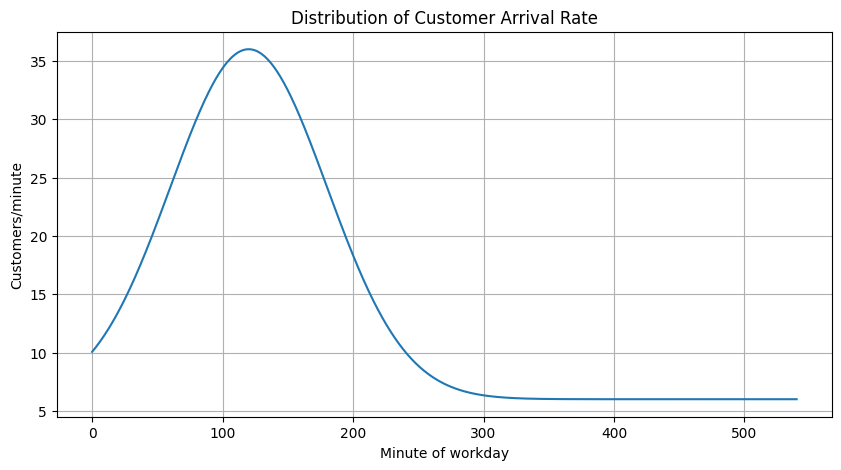

In [37]:
t = np.linspace(0, 540, 1000)   # 9 hours, 1000 points (smooth).

rate = (arrival_rate(t) * 60) # *60 since the arrival_rate returns the arrival rate in minutes. 

plt.figure(figsize=(10,5))
plt.plot(t, rate)
plt.xlabel("Minute of workday")
plt.ylabel("Customers/minute")
plt.title("Distribution of Customer Arrival Rate")
plt.grid(True)
plt.show()

That's the overarching arrival rate, with the rush hour peaking at around 08:30.

The inter-arrival rate (that is, the distribution of the time between arrivals) is exponential, with $ʎ(t)$ = arrival rate at time $t$, and mean inter-arrival time(t) = $1 / ʎ(t)$.

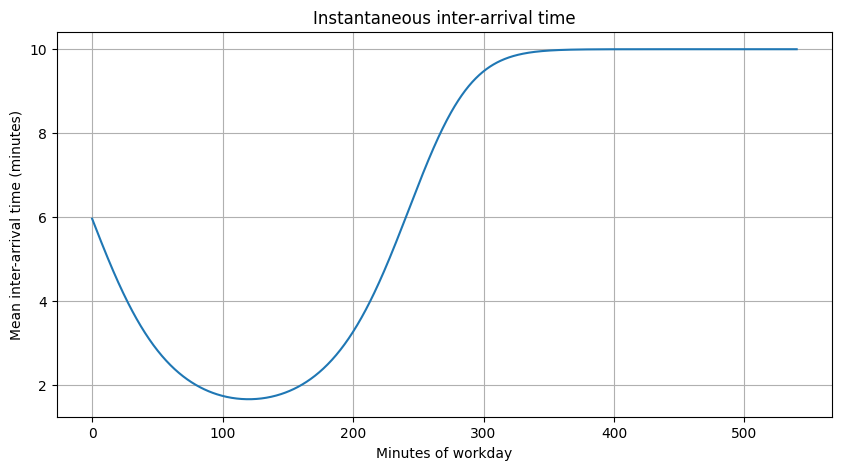

In [38]:
t = np.linspace(0, 540, 1000)
interarrival = 1 / arrival_rate(t)
plt.figure(figsize=(10,5))
plt.plot(t, interarrival)
plt.title("Instantaneous inter-arrival time")
plt.xlabel("Minutes of workday")
plt.ylabel("Mean inter-arrival time (minutes)")
plt.grid(True)
plt.show()

This doesn't illustrate much that hasn't already been illustrated, but shows clearly that circa 10 minutes will pass on average between customers during the baseline (6 customers in 60 minutes) and circa 2 minutes will pass between customer arrivals during the worst of the rush hour.

### Other Global Variables

Notably, we're normalizing everything to SimPy time units = minutes. For the sake of avoiding confusion and ensuring consistency, we will wisely also define seconds, minutes and hours in this context.

* Note that every function that returns a duration should return said value in *minutes*.

Additionally, there are some variables which should be hard-coded in the system. For example, the chance that a coffee machine needs to be utilized in order to complete an order could be something like 90%. In the same vein, the likelihood that an oven needs to be used to complete an order (to heat up a cinnamon bun, or something like that) could be 15%.

The "default variables" for simulations should also be defined here for the sake of good organization. 

The default schedule is:

|           | Shift 1 | Shift 2 | Shift 3 | Shift 4 | Shift 5 | Shift 6 | Shift 7 | Shift 8 | Shift 9 |
| --------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- |
| Registers | 1       | 1       | 1       | 1       | 1       | 1       | 1       | 1       | 1       |
| Baristas  | 2       | 2       | 2       | 2       | 2       | 2       | 2       | 2       | 2       |

This is the café's current schedule, three people on site at all hours. 

The number of machines that their baristas have access to is:

| Coffee Machines | Ovens |
| --------------- | ----- |
| 1               | 1     |

The café owners have also determined that no more than 5 staff members can fit into the same shift, as there is simply not enough space behind the counter. No more than 2 of those can man the registers, as there is not enough physical space to fit more than 2 registers. This means that at maximum a shift could hold either 2 registers and 3 baristas or 1 register and 4 baristas. At minimum, a shift would need at least 1 register and 1 barista as one worker of each kind is needed for the system to function.

In [39]:
# TIME-RELATED GLOBALS - - - - - - - - - - - - - - - - - - - - - - - - - -  
SECONDS = 1/60
MINUTES = 1
HOURS = 60

# LIKELIHOOD-RELATED GLOBALS - - - - - - - - - - - - - - - - - - - - - - -  
CHANCE_THAT_COFFEE_MACHINE_NEEDED = 0.9
CHANCE_THAT_OVEN_NEEDED = 0.15

# SHIFT-CONSTRAINT-RELATED GLOBALS - - - - - - - - - - - - - - - - - - - - 
NUM_TOTAL_STAFF_THAT_FIT_BEHIND_COUNTER = 5
NUM_REGISTERS_THAT_FIT = 2

# DEFAULT NUMBER GLOBALS - - - - - - - - - - - - - - - - - - - - - - - - - 
DEFAULT_NUM_REGISTERS       = 1
DEFAULT_NUM_BARISTAS        = 2 
DEFAULT_NUM_PICKUP_STATIONS = 1 # TODO: We'll take this out at some point. 
DEFAULT_NUM_COFFEE_MACHINES = 1 
DEFAULT_NUM_OVENS           = 1 

The concept of shifts may now be in your recent memory, as it was previously explained that the default for any shift is to have one person at the register and two persons preparing orders. It's worth elaborating on this concept of shifts, as they are one of the variables we will be playing around with.

The café's schedule is made up of shifts. To simplify things, we will make "shifts" synonymous with "hours". That means that 9 different shifts are available in the day, each an hour long. Like so:

| Hour 1 | Hour 2 | Hour 3 | Hour 4 | Hour 5 | Hour 6 | Hour 7 | Hour 8 | Hour 9 |
| ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ |
| Shift 1 | Shift 2 | Shift 3 | Shift 4 | Shift 5 | Shift 6 | Shift 7 | Shift 8 | Shift 9 |

The number of baristas or registers scheduled to be working can change between shifts, but the aforementioned constraints still apply to each and every one of these shifts.

* We must have at least 1 barista and 1 person at the register scheduled for each shift. This is the minimum amount of staff we need for the system to function.
* No more than 2 people can be at the register on any shift, as only 2 actual registers can fit into the space.
* No mpre than 5 people can be expected to fit behind the counter at once.

In [40]:

class Shifts:
    def __init__(self, default_num_registers=1, default_num_baristas=1):
        '''
        The default value for each shift is 1 register and 1 barista, 
        the minimum amount of staff needed for the system to function.

        I also added easy-to-use functions to increase or decrease the count of staff in any shift.
        
        shifts.add_register_to_shift(shift=1, count=1)      --> adds 1 register to shift 1.
        shifts.add_register_to_shift(shift=1, count=2)      --> adds 2 registers to shift 1.
        shifts.remove_register_from_shift(shift=1, count=1) --> removes 1 register from shift 1.

        Each time you modify a shift, the shift automatically gets validated according to the constraints we set 
        (no more than 5 people can fit behind the counter and no more than 2 registers can fit in the space).
        If the shift is not valid, the function will return False.
        If it's valid, then it'll return True and you're free to move on.
        '''

        # If the inputs weren't valid, we return an error.
        validate_inputs = [default_num_registers, default_num_baristas]
        if not self._validate_shift(validate_inputs):
            raise ValueError(f"Invalid initial values: registers={default_num_registers} and baristas={default_num_baristas}.")

        # Else, we put this --> {HOURS_SIMULATED} <-- many identical shifts into a list.
        self.shifts = [[default_num_registers, default_num_baristas] for _ in range(HOURS_SIMULATED)]
        
    def _validate_shift(self, shift):

        # Are there at least one register and one barista?
        if ((shift[0] < 1) or (shift[1] < 1)):
            return False
        
        # Are there more than 5 people behind the counter?
        if ((shift[0] + shift[1]) > NUM_TOTAL_STAFF_THAT_FIT_BEHIND_COUNTER):
            return False
        
        # Are there more registers here than available? 
        if (shift[0] > NUM_REGISTERS_THAT_FIT):
            return False
        
        return True
    
    def _add_employee_to_shift(self, shift_nr, count, employee_type):
        shift = self.shifts[shift_nr - 1]
        shift[employee_type] += count

        if (self._validate_shift(shift)):
            return True
        else:
            shift[employee_type] -= count
            return False
        
    def _remove_employee_from_shift(self, shift_nr, count, employee_type):
        shift = self.shifts[shift_nr - 1]
        shift[employee_type] -= count

        if (self._validate_shift(shift)):
            return True
        else:
            shift[employee_type] += count
            return False
        
    def _add_employee_to_every_shift(self, count, employee_type):
        for shift in self.shifts:
            shift[employee_type] += count

        # If this was a valid action:
        if (all(self._validate_shift(shift) for shift in self.shifts)):
            return True

        # If this was not a valid action:
        for shift in self.shifts:
            shift[employee_type] -= count

        return False
    
    def _remove_employee_from_every_shift(self, count, employee_type):
        for shift in self.shifts:
            shift[employee_type] -= count

        # If this was a valid action:
        if (all(self._validate_shift(shift) for shift in self.shifts)):
            return True

        # If this was not a valid action:
        for shift in self.shifts:
            shift[employee_type] += count

        return False

    def _add_employee_to_shift_range(self, shift_range, count, employee_type):
        '''Should take in a tuple like (2,3) and add {count} of {employee_type} employees to shifts 2 and 3.'''
        for i in range(shift_range[0], shift_range[1]+1):
            e = self._add_employee_to_shift(i, count, employee_type)
            if not e:
                return False # Something went wrong.
        return True
    
    def _remove_employee_from_shift_range(self, shift_range, count, employee_type):
        '''Should take in a tuple like (2,3) and remove {count} of {employee_type} employees from shifts 2 and 3.'''
        for i in range(shift_range[0], shift_range[1]+1):
            e = self._remove_employee_from_shift(i, count, employee_type)
            if not e:
                return False # Something went wrong.
        return True

    def add_register_to_shift(self, shift_nr, count):
        return self._add_employee_to_shift(shift_nr, count, 0)

    def add_barista_to_shift(self, shift_nr, count):
        return self._add_employee_to_shift(shift_nr, count, 1)

    def remove_register_from_shift(self, shift_nr, count):
        return self._remove_employee_from_shift(shift_nr, count, 0)

    def remove_barista_from_shift(self, shift_nr, count):
        return self._remove_employee_from_shift(shift_nr, count, 1)
    
    def add_register_to_every_shift(self, count):
        return self._add_employee_to_every_shift(count, 0)

    def add_barista_to_every_shift(self, count):
        return self._add_employee_to_every_shift(count, 1)
    
    def remove_register_from_every_shift(self, count):
        return self._remove_employee_from_every_shift(count, 0)

    def remove_barista_from_every_shift(self, count):
        return self._remove_employee_from_every_shift(count, 1)

    def add_register_to_shift_range(self, shift_range, count=1):
        return self._add_employee_to_shift_range(shift_range, count, 0)

    def add_barista_to_shift_range(self, shift_range, count=1):
        return self._add_employee_to_shift_range(shift_range, count, 1)
    
    def remove_register_from_shift_range(self, shift_range, count=1):
        return self._remove_employee_from_shift_range(shift_range, count, 0)

    def remove_barista_from_shift_range(self, shift_range, count=1):
        return self._remove_employee_from_shift_range(shift_range, count, 1)


* I may have gone a bit overboard adding functions we'll never use, but alas. We have this easy-to-use class.

This structure should hopefully help keep things clear and organized when it comes to the matter of experimentation. 

It's worth noting that, in SimPy, a resource that's created with a certain capacity cannot have its capacity spontaneously "updated" or "adjusted". This makes implementing the change in resource capacities between shifts a tad tricky. This will be done with the aide of a store or sorts. Thus, we define a "shift_manager" to aide in the transition between shifts.

In [41]:
def adjust_staff(role, count, current, pool, hour):
    '''
    shift_manager's helper.
    Adjusts the staff count for the given role at shift change.

    - role:         Str.        "register" or "barista".
    - count:        Int.        Scheduled staff count at this hour.
    - current:      Int.        Current staff count in the shift record
    - pool:         Store.      Pool of staff.
    - hour:         Int.        Current simulation hour.
    '''

    # If we need more staff:
    if (count > current):
        for _ in range(count - current):
            yield pool.put(f"{role}_{hour}")

    # If we need less staff:
    elif (count < current):
        # Note that we're only removing staff that's free. We won't remove someone when they're in the middle of making an order. We'll let them finish.
        remove_count = (current - count)
        for _ in range(remove_count):
            if len(pool.items) > 0:
                yield pool.get()

    # And if we already have the correct amount of staff, nothing changes.
    else:
        pass


def shift_manager(env, shifts, register_pool, barista_pool, current_shift):
    '''
    Every hour, updating the number of registers and baristas according to schedule.
    
    NOTE: shift.shifts[hour] = [# registers, # baristas]
    '''

    registers_scheduled, baristas_scheduled = shifts.shifts[0]
    current_shift["registers"] = registers_scheduled
    current_shift["baristas"] = baristas_scheduled

    hour = 1
    while (hour < HOURS_SIMULATED):

        yield env.timeout(60) # The shift passes (1 hour, always).

        registers_scheduled, baristas_scheduled = shifts.shifts[hour]

        # - - - - - REGISTERS - - - - -

        yield from adjust_staff(
            role="register",
            count=registers_scheduled,
            current=current_shift["registers"],
            pool=register_pool,
            hour=hour
        )
        current_shift["registers"] = registers_scheduled

        # - - - - - BARISTAS - - - - -

        yield from adjust_staff(
            role="barista",
            count=baristas_scheduled,
            current=current_shift["baristas"],
            pool=barista_pool,
            hour=hour
        )
        current_shift["baristas"] = baristas_scheduled

        # - - - ... and the shift passes. - - - 
        hour += 1 


The "register_pool" and "barista_pool" are both SimPy "Store" resources. That is, Register and Barista resources are stored in these "pools", respectively. A staff member can then be aquired with "{staff_type} = yield {staff_type}_pool.get()". 

Every hour, the shift manager adjusts the schedule such that we'll have the scheduled amount of each employee. It's worth noting that each employee will "finish what they were doing" (in a sense) before "leaving their shift". The shift_manager only shoos away those employees currently idle when the shift changes, the employees finishing a task will simply not be available anymore after they finish what they were doing.



### Metrics to track

The purpose of simulating this process is to minimize the waiting time for customers while maximizing resource utilization. There are several related metrics worth keeping track of, including:
1) Customer waiting time.
    - From when the customer arrives to the cafe to when their order is ready, how much did they have to wait?
    - Aside from the total wait time, it's also possible to split their wait into three sections:
        1) Waiting in line.
        2) Making their order. <-- not really "waiting" if they're actively doing something. Should we still include this in the total?
        3) Waiting while their order is prepared.
2) Resource busy/idle time.
    - Uhhhhh *we'll fill this in once that part of the code is ready.

It's also a good idea to keep track of more general things, such as:
- Number of customers.
- How long from when an order is placed until preparation begins?
- *we may think of other things. Maybe queue lengths? I could see that maybe being marginally helpful.

In [42]:
class Stats:
    '''A class to keep track of the numbers for each simulation.'''

    def __init__(self):

        # - - - GENERAL INFO - - - - - - - - - - - - - - - - - - -

        self.run_seed = 0

        # - - - CUSTOMER-RELATED NUMBERS - - - - - - - - - - - - -

        # TIME-TRACKING
        self.register_queue_time = []           # Time each customer spent waiting to place their order.
        self.pickup_queue_time = []             # Time each custimer spent picking up their order. TODO: We were going to take this out, right?
        self.total_time_in_system = []          # Total time each customer spent from arrival time to pickup time.
        
        self.time_until_prep_begins = []        # The time from the customer places the order until a barista begins working on it.
        self.arrival_times = []                 # For plotting. TODO: Can be taken out later, for the sake of saving storage space.

        # TODO: Experimental.
        self.per_hour = {
            "arrivals":                 ([0] * HOURS_SIMULATED),
            "completed_orders":         ([0] * HOURS_SIMULATED),
            # TODO: Add this stat and get it to work.
            #"avg_queue_len_register":   [[] for _ in range(HOURS_SIMULATED)],
            "avg_wait_time":            [[] for _ in range(HOURS_SIMULATED)],
        }

        # OTHER HELPFUL MEASURES
        self.num_customers = 0
        
        # TODO: Am I filling these anywhere?
        self.avg_length_register_queue = []     # This is a list because we might also want to graph this. Average length of queue per every hour, or something.
        self.avg_length_pickup_queue = []       # I don't think this has ever not been 0. I'm tracking it for the sake of consistency, though.
        self.avg_count_customers_waiting = []   # Could also be cool to graph.

        # - - - RESOURCE UTILIZATION - - - - - - - - - - - - - - -

        # STAFF BUSYNESS
        self.register_busy_time = 0.0           # Total minutes all registers spent actively serving customers.
        self.barista_busy_time = 0.0            # Total minutes all baristas spent preparing orders.
        self.register_time_available = 0.0      # Total register minutes available from shift schedule. NOTE: Idle time = register_time_available - register_busy_time.
        self.barista_time_available = 0.0       # Total barista minutes available from shift schedule. Similar NOTE: Idle time = barista_time_available - barista_busy_time.

    def compute_staff_time_available(self, shifts, minutes_per_hour=HOURS): # NOTE: HOURS is a global currently set to 60. The amount of minutes in an hour.
        '''
        Computes the total available staff time from shifts for each staff type, given the shifts.'''

        self.register_time_available = 0.0  # Must always reset to 0.
        self.barista_time_available = 0.0

        for hour, (registers, baristas) in enumerate(shifts.shifts):
            self.register_time_available += (registers * minutes_per_hour)
            self.barista_time_available  += (baristas * minutes_per_hour)

    @property
    def register_utilization(self):
        '''Fraction of total scheduled register time that was spent busy. (Register utilization %).'''
        if (self.register_time_available == 0):
            return 0.0
        
        return (self.register_busy_time / self.register_time_available)
    
    @property
    def barista_utilization(self):
        '''Fraction of total scheduled barista time that was spent busy. (Barista utilization %).'''
        if (self.barista_time_available == 0):
            return 0.0
        
        return (self.barista_busy_time / self.barista_time_available)






### Time distributions defined

*Insert text on time distributions.

Note that these should all return the time in minutes.

In [43]:
def order_time(rng):
    '''How long it takes a customer to order, in minutes.'''
    sample = 10 + rng.gamma(5, 11)      # Shape=5, scale=11, then +10 sec base.
    return (min(sample, 120) * SECONDS) # Hard max cutoff: 2 minutes = 120 seconds.

 
def making_order_time(rng):
    '''
    How long it takes to get the order ready.
    TODO: We might want to change this process later, add coffe machines and such as resources, and so on.
    For now though, it's just a distribution like so.
    
    Triangular distribution: min=15s, mode=3min, max=10min.
    '''
    return (rng.triangular(15, 3*60, 10*60) * SECONDS)


# TODO: This will not remain.
# It's gotta take at least a second.
# I'm just going to be optimistic and guess that the mean is 5 seconds, and the std is 1.
def pickup_time(rng):
    '''How long it takes the customer to pick up the order.'''
    return (max(1, rng.normal(5, 1)) * SECONDS)


# Uniform distribution, minimum 0.5 minutes and maximum 2 minutes.
def coffee_machine_time(rng):
    '''How long it takes the barista to use the coffee machine for a given order.'''
    return (rng.uniform(low=30, high=120) * SECONDS)


# Uniform distribution, minimum 1 minute maximum 5 minutes (just to heat things up).
def oven_time(rng):
    '''How long it takes the barista to use the oven for a given order.'''
    return (rng.uniform(low=60, high=300) * SECONDS)

### Helpers

In [44]:
def use_coffee_machine(env, ID, coffee_machine, rng):
    '''If a barista needs to use a coffee machine, this function will run.'''

    with (coffee_machine.request() as req):
        yield req
        time = coffee_machine_time(rng)
        #print(f"{ID} using coffee machine for {time:.2f} seconds at {env.now:.2f}.")
        yield env.timeout(time)

def use_oven(env, ID, oven, rng):
    '''If a barista needs to use an oven, this function will run.'''

    with (oven.request() as req):
        yield req
        time = oven_time(rng)
        #print(f"{ID} using oven for {time:.2f} seconds at {env.now:.2f}.")
        yield env.timeout(time)

Baristas may well need to use a coffee machine or an oven to finish a given order. These actions are placed in their own functions primarily for increased ease of readibility later in the file.

### Meatier functions

In [45]:

def customer(env, stats_keeper, ID, register_pool, barista_pool, pickup, coffee_machine, oven, rng, current_shift):
    '''
    Customer's "lifecycle".
    A customer arrives to wait in line, orders + pays, waits while a barista prepares their order, and then pick up their order when it's ready.
    
    Note that the baristas may also use resources such a coffee machine or oven, and the availability of such devices affects the customer's waiting time.
    
    Params:
        - env:              simpy.Environment.  The environment of this current run.
        - stats_keeper:     Stats.              Used for collecting stats on the simulation run.
        - ID:               Int.                The customer's ID.
        - register_pool:    simpy.Store.        Stores registers, which are of the type simpy.Resource.
        - barista_pool:     simpy.Store.        Stores baristas, which are of the type simpy.Resource.
        - pickup:           simpy.Resource.     The spot where you pick up your drink.
        - coffee_machine:   simpy.Resource.     The baristas likely need to use it to prepare your order.
        - oven:             simpy.Resource.     The baristas may need to use it to prepare your order.
        - rng:              Generator.          A random number generator (RNG).
        - current_shift:    Int.                The number of the hour.
    '''

    arrival = env.now
    #print(f'{ID} arrives at {arrival:.2f}')
    stats_keeper.num_customers += 1
    hour = int(env.now // 60)
    stats_keeper.per_hour["arrivals"][hour] += 1



    # TODO: I could refactor these "acts" into different function. For readibility. 

    # # # # # # # # # # # # # # 
    #   ACT I: The Register   #
    # # # # # # # # # # # # # # 
    register = yield register_pool.get()        # Acuiring staff member.
    
    start_ordering = env.now
    #print(f"{ID} begins ordering at {start_ordering:.2f}")
    ordering = order_time(rng)
    stats_keeper.register_busy_time += ordering # All registers together are busy for "ordering" minutes here.
    yield env.timeout(ordering)                 # We wait while the customer places their order.
    
    stop_ordering = env.now
    #print(f"{ID} finishes ordering at {stop_ordering:.2f}")

    # Releasing staff member:
    yield register_pool.put(register)

    # # # # # # # # # # # # # # 
    #   ACT II: The Waiting   #
    # # # # # # # # # # # # # # 
    # The barista may need to #
    # use the coffee machine  #
    # and/or oven to complete #
    # the order, and on top   #
    # of that some time gets  #
    # added.                  #
    # # # # # # # # # # # # # # 

    barista = yield barista_pool.get()
    prep_begin = env.now
    #print(f"{ID}'s order preperation begins at {prep_begin:.2f}")

    # The time it takes to get an order ready is:
    #
    #       time using coffee machine   Distribution: Uniform
    #   +   time using oven             Distribution: Uniform
    #   +   general prep time           Distribution: Triangle
    #   =   total time                  Distribution: Looks a bit sillier

    needs_coffee =  rng.random() < CHANCE_THAT_COFFEE_MACHINE_NEEDED
    needs_oven =    rng.random() < CHANCE_THAT_OVEN_NEEDED
    
    if (needs_coffee):
        yield env.process(use_coffee_machine(env, ID, coffee_machine, rng))
    if (needs_oven):
        yield env.process(use_oven(env, ID, oven, rng))

    prep_time = making_order_time(rng)
    yield env.timeout(prep_time)

    # - - - - - - - - - - Order finished! - - - - - - - - - -

    time_ready = env.now
    #print(f"{ID}'s is ready for pickup at {time_ready:.2f}")

    stats_keeper.barista_busy_time += (time_ready - prep_begin) # Tracking how long baristas were busy on this order.

    # The barista then leaves if their shift is over.
    if (len(barista_pool.items) < current_shift["baristas"]):
        yield barista_pool.put(barista)
    else:
        #print(f"Barista finishes and goes off shift at {env.now:.2f}")
        pass

    # # # # # # # # # # # # # # 
    #   ACT III: The Pickup   #
    # # # # # # # # # # # # # #
    with pickup.request() as req:
        yield req

        start_pickup = env.now
        #print(f"{ID} goes to pick up their order at {start_pickup:.2f}")

        pickupp_time = pickup_time(rng)
        yield env.timeout(pickupp_time)

        end_time = env.now
        #print(f"{ID} leaves at {end_time:.2f}")
        
    hour = int(env.now // 60)
    stats_keeper.per_hour["completed_orders"][hour] += 1
    stats_keeper.per_hour["avg_wait_time"][hour].append(end_time - arrival)


    # # # # # # # # # # # # # # #
    #   ALSO: Gathering Stats   #
    # # # # # # # # # # # # # # #

    time_in_register_queue  = max(0, (start_ordering - arrival))
    time_in_pickup_queue    = max(0, (time_ready - start_pickup))
    total_time              = max(0, (end_time - arrival))

    stats_keeper.register_queue_time.append(time_in_register_queue)
    stats_keeper.pickup_queue_time.append(time_in_pickup_queue)
    stats_keeper.total_time_in_system.append(total_time)

    time_from_order_to_prep_start = max(0, (time_ready - prep_begin))
    stats_keeper.time_until_prep_begins.append(time_from_order_to_prep_start)


Here the customer's "lifecycle" is simulated. After the customer arrives at the café, they'll wait in line (unless the line is empty, in which case they'll march right up to the register), they'll order, and then they'll wait until their order is ready. We care only about what happens before the customer receives their drink, and thesefore do not simulate the customer leaving the café or finding a seat.

In [46]:

def arrivals_generator(env, stats_keeper, register_pool, barista_pool, pickup, coffee_machine, oven, arrival_rate, current_shift, rng):
    '''
    Generates arrivals of customers according to the chosen arrival_rate.
    Runs the 'customer' process for each of the arrivals.

    Params:
        - env:              simpy.Environment.  The environment of this current run.
        - stats_keeper:     Stats.              Used for collecting stats on the simulation run.
        - register_pool:    simpy.Store.        Stores registers, which are of the type simpy.Resource.
        - barista_pool:     simpy.Store.        Stores baristas, which are of the type simpy.Resource.
        - pickup:           simpy.Resource.     The spot where you pick up your drink.
        - coffee_machine:   simpy.Resource.     The baristas likely need to use it to prepare your order.
        - oven:             simpy.Resource.     The baristas may need to use it to prepare your order.
        - arrival_rate:     A function.         Returns the "customers per minute" arrival rate based on the the current time.
        - current_shift:    Int.                The number of the hour.
        - seed:             int.                Seed for a random number generator.
    '''

    customer_ID = 0
    inter_arrival = 0
    while True:

        if ((env.now + inter_arrival) >= OPEN_FOR):
            #print(f"\nCLOSING SHOP. \nNo more arrivals after closing at {OPEN_FOR:.2f}.\n")
            return

        rate = arrival_rate(env.now)
        inter_arrival = rng.exponential(1 / rate)       # Inter arrival from exponential dist.
        yield env.timeout(inter_arrival)                # Waiting until the next arrival.

        arrival_time = env.now                          # For plotting.
        stats_keeper.arrival_times.append(arrival_time)

        env.process(customer(
            env,
            stats_keeper,
            customer_ID,
            register_pool,
            barista_pool,
            pickup,
            coffee_machine,
            oven,
            rng,
            current_shift
        ))
        customer_ID += 1

The arrivals_generator, living up to its name, generates customer arrivals. 

It's worth repeating that the café stops serving new customers at {OPEN_FOR} minutes into the day, and the simulation itself ends at {CLOSES}. The employees should ideally be able to finish up any orders before closing up for the day.

In [47]:
def simulate(shifts, num_pickups, num_coffee_machines, num_ovens, arrival_rate, ttl, seed=None):
    '''
    Simulates the process with the specified:
        - shifts:               Shifts.     Contained the scheduled shifts.
        - num_pickups:          Int.        Number of places where drinks can be picked up.
        - num_coffee_machines:  Int.        Number of coffee machines which baristas have at their disposal.
        - num_ovens:            Int.        Number of ovens which baristas have at their disposal.
        - arrival_rate:         Function.   Returns the arrival rate in customers per minute.
        - ttl:                  Float.      "time-to-live", how long the simulation will be allowed to run (in case there are some customers still awaiting their orders).

    Returns:
        - statistics:           Stats.  The numbers for this particular simulation run.
    '''
    
    env = simpy.Environment()
    rng = np.random.default_rng(seed)
    statistics = Stats()

    statistics.compute_staff_time_available(shifts, minutes_per_hour=HOURS) # Precomputing how many staff-minutes we have on the schedule.

    # < - - - STAFF POOLS - - - >
    # The number of available resources depends on which shift we're on. (Shift == hour)
    register_pool = simpy.Store(env)
    barista_pool  = simpy.Store(env)
    # So instead of changing the capacity of resources (which isn't possible) we use a store to hold staff objects. We can then add and remove thse objects at shift changes.

    # Initializing shift 1 staff:
    first_shift_num_registers, first_shift_num_baristas = shifts.shifts[0]
    for i in range(first_shift_num_registers):
        register_pool.put(f"register_0")
    for i in range(first_shift_num_baristas):
        barista_pool.put(f"barista_0")

    pickup = simpy.Resource(env, capacity=num_pickups)
    coffee_machine = simpy.Resource(env, capacity=num_coffee_machines)
    oven = simpy.Resource(env, capacity=num_ovens)

    # This is to track the current shift's capacity.
    current_shift = {
        "registers": first_shift_num_registers,
        "baristas": first_shift_num_baristas
    }

    # Starting the shift manager:
    # def shift_manager(env, shifts, register_pool, barista_pool, current_shift)
    env.process(shift_manager(env, shifts, register_pool, barista_pool, current_shift))

    # Starting the arrivals:
    env.process(arrivals_generator(
        env=env, 
        stats_keeper=statistics,
        register_pool=register_pool,
        barista_pool=barista_pool,
        pickup=pickup,
        coffee_machine=coffee_machine,
        oven=oven,
        arrival_rate=arrival_rate,
        current_shift=current_shift,
        rng=rng
    ))
    env.run(until=ttl)

    return statistics


def total_size(obj, seen=None):
    '''
    TODO: Function given by ChatGPT. I will remove this when it's no longer needed.
    Recursively find size of objects including contents.
    '''
    if seen is None:
        seen = set()
    size = sys.getsizeof(obj)
    obj_id = id(obj)

    if obj_id in seen:
        return 0
    seen.add(obj_id)

    if isinstance(obj, dict):
        size += sum(total_size(v, seen) for v in obj.values())
        size += sum(total_size(k, seen) for k in obj.keys())
    elif isinstance(obj, (list, tuple, set, frozenset)):
        size += sum(total_size(i, seen) for i in obj)

    return size

def run_simulations(e, exp_seed=None):
    '''
    Runs the simulation several times.
    Input:  An instance of an Experiment and a seed for randomness.
    Output: A list of Stats, one for each run.
    '''
    exp_rng = np.random.default_rng(exp_seed)
    all_stats = []

    for i in range(e.num_of_simulations):

        per_run_seed = exp_rng.integers(0, (2**63)-1) # Making a per-run seed from the experiment's RNG.

        stats = simulate(
            shifts=e.shifts, 
            num_pickups=e.num_pickups, 
            num_coffee_machines=e.num_coffee_machines, 
            num_ovens=e.num_ovens, 
            arrival_rate=e.arrival_rate, 
            ttl=e.ttl,
            seed=per_run_seed
        )
        stats.run_seed = int(per_run_seed)
        all_stats.append(stats)

    return all_stats


As the plan is to simulate this corner of the workday several times, both with the default values and with many experimental changes, we found it necessary to have a function which runs one single simulation, as well as one that runs several simulations with the same parameters.

## The Experimental Setup

| Understaffing | Average staffing | High staffing | Full staffing V1 | Full Staffing V2 |
| ------------- | ---------------- | ------------- | ---------------- | ---------------- |
| (1,1)         | (1,2)            | (1,3)         | (2,3)            | (1,4)            |

For our main experiments, the staffing will remain the same throughout most of the day but will be changed during the rush hour period. We will try average staffing, high staffing and full staffing, but  will be skipping understaffing as we already know it will not suffice.

For each of these scenarios, we will additionally be testing different numbers of machinery.

| Coffee Machine | Oven |
| -------------- | ---- |
| 1              | 1    |
| 2              | 1    |
| 3              | 1    |
| 1              | 2    |
| 2              | 2    |

In [48]:

# The shifts are automatically set to 1 register and 1 barista for every shift (the bare minimum). 
# The "original" shifts at this café consisted of 1 register and 2 baristas at all hours.
BARE_MINIMUM = Shifts()                                 # All (1,1) by default. The minimum employees needed for functioning.
AVERAGESTAFFED = Shifts(1,2)                            # The ORIGINAL schedule, where there's 1 register and 2 baristas on the clock at all hour.

print(AVERAGESTAFFED)

UNDERSTAFFED = copy.deepcopy(AVERAGESTAFFED)
UNDERSTAFFED.remove_barista_from_shift_range(RUSH_HOUR) # (1,1) during rush hour. TODO: I don't see why we'd want to test this? Idk, let's discuss on monday.

HIGHSTAFFED = copy.deepcopy(AVERAGESTAFFED)
HIGHSTAFFED.add_barista_to_shift_range(RUSH_HOUR)       # (1,3) during rush hour, schedule stays at (1,2) during all other hours.

FULLSTAFFED_1 = copy.deepcopy(HIGHSTAFFED)
FULLSTAFFED_1.add_register_to_shift_range(RUSH_HOUR)      # (2,3) during rush hour, schedule stays at (1,2) during all other hours.

# TODO: In case the register queue isn't the bottleneck we think it is (I have good reason to believe this), we should maybe try the (1,4) combo as well.
# Note that I haven't set up this test yet, though.
FULLSTAFFED_2 = copy.deepcopy(HIGHSTAFFED)
FULLSTAFFED_2.add_barista_to_shift_range(RUSH_HOUR)       # (1,4) during rush hour, schedule stays at (1,2) during all other hours.


DEFAULT_NUM_SIMULATIONS = 30 # TODO: Change to something else. Or don't. 
# DEFAULT_NUM_SIMULATIONS = 100 # I found that 30 did not seem to be enough.
# DEFAULT_NUM_SIMULATIONS = 500 # I found that 100 did not seem to be enough.
# TODO: I give up. Maybe the issue is moreso with the comparison functions.

class Experiment:
    '''
    A class representing a single experiment.
    The ID is the only required input. I could've just made it 0 by default, 
    but I wanted to make super sure that adding it isn't forgotten.
    '''

    def __init__(self, ID, num_of_simulations=DEFAULT_NUM_SIMULATIONS):
        self.ID                     = ID                            # Nr. of experiment. 
        self.num_of_simulations     = DEFAULT_NUM_SIMULATIONS       # Whatever number we've decided will suffice.
        self.shifts                 = UNDERSTAFFED                  # The minimum amount of staff needed for the system to function is 1 register and 1 barista.
        self.num_pickups            = num_of_simulations            # TODO: We are still considering removing this, right?
        self.num_coffee_machines    = DEFAULT_NUM_COFFEE_MACHINES   # 1 by default.
        self.num_ovens              = DEFAULT_NUM_OVENS             # 1 by default.
        self.arrival_rate           = arrival_rate                  # The customer arrival rate.
        self.ttl                    = CLOSES                        # The simulation ends after {CLOSES} minutes.


We'll also want to introduce some randomness, so that all simulation runs are not the same. To keep things both replicatable and VERY simple, these pre-determined seeds will just mirror the tables above.

In [49]:
expr_nr_seed        = ["1", "2", "3", "4"]
machines_nr_seed    = ["one_one", "one_two", "one_three", "two_one", "two_two"]
exp_seeds           = ([0] * (len(expr_nr_seed) * len(machines_nr_seed)))

seed_i = 0
for i in expr_nr_seed:
    for j in machines_nr_seed:
        seed_combo = f"{i}_{j}"
        seed_value = abs(hash(seed_combo)) % (2**63) # SeedSequence expects int or sequence of ints for entropy.
        seed_i += 1

'exp_seeds' thus includes seeds on the format ["1_one_one", "1_one_two", ...] and so on.

This makes for a total of (expr_nr_seed x machines_nr_seed) = 20 experiments, but not all will be analyzed in-depth. We will simply automate the process of finding the ideal number of each type of machine for the amount of staffing, and then analyze that ideal situation. 

NOTE: Text not entirely true, we will make a table or something with the amount of machines in relation to the staffing and then talk about it, but not super in-depth.

In [50]:
#           UNDER-      AVERAGE-    HIGH-       FULL-
staffing = [(1,1),      (1,2),      (1,3),      (2,3)]

#           (# coffee machines, # ovens)
machinery = [(1,1), (2,1), (3,1), (1,2), (2,2)]

#### Helpers for analyzing and comparing results

# NOTE: Right now I have too many.

We won't be using all of these, methinks. Also DES_5.pdf is important here.

##### For individual runs:

In [51]:
# TODO: This will probably not be that useful, since individual runs don't actually tell us a whole lot.

def print_stats(statistics):
    '''The stats for each simulation run on a printed format.'''

    # - - - CUSTOMER WAIT-TIME - - - - -
    print("# Customers:", statistics.num_customers)
    print("Total times in register queue:\n", statistics.register_queue_time)
    print("Time from when the order is placed until a barista begins working on it:\n", statistics.time_until_prep_begins)
    print("Total times in pickup queue:\n", statistics.pickup_queue_time)
    print("Total times in system:\n", statistics.total_time_in_system)

    # - - - EMPLOYEE UTILIZATION - - - - -
    print(f"Total register busy time (all registers): {statistics.register_busy_time:.2f} minutes")
    print(f"Total barista busy time (all baristas):  {statistics.barista_busy_time:.2f} minutes")

    print(f"Register utilization: {statistics.register_utilization * 100:.1f}%")
    print(f"Barista utilization:  {statistics.barista_utilization * 100:.1f}%")

##### Average numbers across runs:

In [52]:
def avg(results, function_name):
    return np.mean([function_name(s) for s in results])

def get_avg_of(results, attr):
    return avg(results, lambda s: getattr(s, attr))

def print_all_averages(results):
    '''
    Loops over all attributes in the results, prints the average value for each.
    NOTE: 'all' is excluding the per-hour measurements. 
          See print_all_averages_per_hour for that.
    '''

    attrs = vars(results[0]).keys()
    for i in attrs:

        attr = getattr(results[0], i)
        if isinstance(attr, dict):      # Skipping the 'per_hour' dict.
            continue

        avg_attr = get_avg_of(results, i)

        if not (avg_attr != avg_attr):  # Checkig if NaN.
            print(f"Avg. '{i}':".ljust(35) + f"{avg_attr:.2f}")


##### Average numbers across runs, --> *per hour* <--:

In [53]:
def helper_numeric_per_hour(results, per_hour, key, out):
    '''
    Builds a numeric array of shape (number of runs x HOURS_SIMULATED).
    Computes the mean across runs for that metric.
    '''
    arr = np.array([np.array(result.per_hour[key], dtype=float) for result in results])
    out[key] = np.nanmean(arr, axis=0)


def helper_list_of_samples_per_hour(results, runs, key, out):
    '''
    Computing a per-hour means for each run (hour's samples --> mean), 
    then averaging the per-hour means across runs.
    Used for keys whose per-hour data are lists of samples [[...], [...], ... etc.].
    '''
    per_run_hour_means = np.full((runs, HOURS_SIMULATED), np.nan, dtype=float)

    for run, result in enumerate(results):
        for hour in range(HOURS_SIMULATED):
            samples = result.per_hour[key][hour]
            if samples:
                per_run_hour_means[run, hour] = np.mean(samples)

    out[key] = np.nanmean(per_run_hour_means, axis=0)


def get_all_averages_per_hour(results):
    '''
    Summarizing per-hour entries across multiple simulation runs.

    2 cases as of right now:
        1) Numeric per-hour
            Like [1, 2, 3, ...]
            We directly acerage across runs.
        2) List of samples per-hour
            Like [[1, 2, 3, ...], ...]
            We first compute the per-hour mean per run, 
            then average that across runs.

    Returns a dict mapping each per-hour key to a vector of length HOURS_SIMULATED.
    '''

    per_hour = results[0].per_hour
    keys = list(per_hour.keys())
    runs = len(results)

    out = {}

    for key in keys:
        first = per_hour[key]

        is_correct_length       = (isinstance(first, (list, tuple)) and len(first) == HOURS_SIMULATED)
        is_flat_numeric_list    = all(not isinstance(x, (list,tuple)) for x in first)
        contains_nested_lists   = any(isinstance(x, (list,tuple)) for x in first)

        # - - - NUMERIC-PER-HOUR - - - - -
        if (is_correct_length and is_flat_numeric_list ):
            helper_numeric_per_hour(results, per_hour, key, out)

        # - - - LIST-OF-SAMPLES-PER-HOUR - - - - - 
        elif (is_correct_length and contains_nested_lists):
            helper_list_of_samples_per_hour(results, runs, key, out)

        # - - - WE DON'T KNOW WHAT WE'RE LOOKING AT - - - - -
        else:
            try: # If this doesn't work out, we just skip it.
                arr = np.array([np.array(r.per_hour[key]) for r in results], dtype=float)
                out[key] = np.nanmean(arr, axis=0)
            except Exception:
                print(f"Skipping '{key}' (unsupported per_hour shape).")
                out[key] = None

    return out
    

def print_all_averages_per_hour(results, decimals=3):
    '''
    Prints the per-hour averages for each key.
    (Decimals are 3 by default but we can make it whateverr).
    '''
    
    averages = get_all_averages_per_hour(results)
    fmt = f"{{:.{decimals}f}}"  # e.g. "{:.3f}"
    print("\nPer hour averages across runs:\n")

    for key, vec in averages.items():
        print(f"\t{key}:")
        if vec is None:
            print(f"\t[unsupported shape]\n")
            continue

        # Formatting according to specified decimal number:
        formatted = [fmt.format(x) if isinstance(x, (int, float)) and not np.isnan(x) else x for x in vec]
        print(f"\t{formatted}\n")

##### For visualization:

Single-run:

In [54]:
# TODO: Plotting, scheming.
# I already had some plotting functions ready, they were made with only single-runs in mind though.
# Can I adapt them to these multi-run numbers?

def plot_customer_waiting_times(stats):
    plt.plot(stats.total_time_in_system)
    plt.ylabel('Waiting time for customers 0 to i')
    plt.xlabel('# Customer')
    plt.show()

def plot_customer_register_queue_waiting_times(stats):
    plt.plot(stats.register_queue_time)
    plt.ylabel('Waiting time in register queue for customers 0 to i')
    plt.xlabel('# Customer')
    plt.show()

def plot_customer_waiting_times_after_queue(stats):
    # Waiting time after queue: total_time_in_system - register_queue_time
    # TODO: This function has not been tested.
    plt.plot((stats.total_time_in_system - stats.register_queue_time))
    plt.ylabel('Waiting time outside of register queue for customers 0 to i')
    plt.xlabel('# Customer')
    plt.show()

def plot_waiting_times_until_order_prep_begins(stats):
    plt.plot(stats.time_until_prep_begins)
    plt.ylabel('Waiting time until barista begins working on order for customers 0 to i')
    plt.xlabel('# Customer')
    plt.show()

# TODO: Add the rest. Mostly copy-paste.

def plot_stats(statistics):
    '''To avoid having to repeat all of these lines.'''
    plot_customer_waiting_times(statistics)
    plot_customer_register_queue_waiting_times(statistics)
    plot_waiting_times_until_order_prep_begins(statistics)
    

def plot_arrivals(statistics):
    '''
    TODO: This is... pretty useless since we already know the arrival distribution? 
          AND we already plotted it for those who'll read this notebook?
    Plots arrivals as a scatter plot + rate histogram.
    '''

    arrivals = statistics.arrival_times
    
    plt.figure(figsize=(10,4))

    # Scatter plot:
    plt.scatter(arrivals, [0]*len(arrivals), s=10)
    plt.title("Arrivals Scatter Plot")
    plt.xlabel("Time (minutes)")
    plt.yticks([])
    plt.show()

    # Histogram:
    plt.figure(figsize=(10,4))
    plt.hist(arrivals, bins=30)
    plt.xlabel("Time (minutes)")
    plt.ylabel("# Arrivals")
    plt.title("Arrivals Histogram")
    plt.show()

Multi-run:

In [55]:

def plot_all_averages_per_hour(results, excluding=("arrival",)):
    '''We already have a function that prints these averages, I figured a graph would be more easily digestible to readers.'''

    averages = get_all_averages_per_hour(results)

    keys_to_plot = [
        key for key in averages.keys()
        if averages[key] is not None and not any(ex in key.lower() for ex in excluding)
    ]
    num_plots = len(keys_to_plot)

    fig, axes = plt.subplots(num_plots, 1, figsize=(8, (3*num_plots)))
    if (num_plots == 1): # I think it'll never be 1, but just in case...
        axes = [axes]

    for i, j in zip(axes, keys_to_plot):
        vec = averages[j]
        hours = np.arange(len(vec))
        i.plot(hours, vec, marker='*')
        i.set_title(f"{j}: Per-hour avg. over {DEFAULT_NUM_SIMULATIONS} simulation runs.")
        i.set_ylabel("Average")
        i.set_xlabel("Hour")
        i.grid(True, linestyle='--', alpha=0.6)

    axes[-1].set_xlabel("Hour of Day")
    plt.tight_layout()
    plt.show()

    

# TODO: Some of the graphs below are kind of trash. I need to go over them.


def plot_customer_waiting_times_multi(results):
    '''The average total waiting time for customer index 0 to N across multiple simulation runs.'''

    min_len = min(len(result.total_time_in_system) for result in results)           # Min length of total_time_in_system defined, so all runs can be aligned safely...
    arr = np.array([result.total_time_in_system[:min_len] for result in results])   # Matrix: (num_runs × min_len)

    avg_vals = np.mean(arr, axis=0) # Mean and standard deviation.
    std_vals = np.std(arr, axis=0)

    plt.figure(figsize=(10,5))
    plt.plot(avg_vals, label="Mean waiting time (minutes)")
    plt.fill_between(range(min_len), (avg_vals - std_vals), (avg_vals + std_vals), alpha=0.2, label="±1 std dev")
    plt.ylabel("Waiting time (minutes)")
    plt.xlabel("# Customer")
    plt.legend()
    plt.title("Mean total customer waiting time across runs (minutes).")
    plt.show()

def plot_register_queue_waiting_times_multi(results):
    '''Same as plot_customer_waiting_times_multi but for waiting time in queue.'''
    min_len = min(len(s.register_queue_time) for s in results)
    arr = np.array([s.register_queue_time[:min_len] for s in results])

    plt.figure(figsize=(10,5))
    plt.plot(np.mean(arr, axis=0))
    plt.ylabel("Register queue time (minutes)")
    plt.xlabel("# Customer")
    plt.title("Mean register queue waiting time across runs (minutes).")
    plt.show()

# TODO: def plot_waiting_time_outside_of_queue_multi(results):

def plot_distribution_across_runs(results, attr):
    '''Histogram of the mean value of a given Stats attribute across runs...'''
    
    vals = []
    
    for s in results:
        value = getattr(s, attr)
        if (isinstance(value, list)):
            vals.append(np.mean(value))
        else:
            vals.append(value)

    plt.hist(vals, bins=15)
    plt.title(f"Distribution of avg. '{attr}' across runs.")
    plt.xlabel(attr)
    plt.ylabel("# Run")
    plt.show()

def plot_per_hour(results, key):
    '''Per-hour averages for a per_hour metric across runs, now PLOTTED!!'''
    all_avg_per_hour = get_all_averages_per_hour(results)
    vals = all_avg_per_hour[key]

    plt.figure(figsize=(8,4)) # TODO: Find most beautiful size. TODO: Same for the other plots, obvi.
    plt.plot(vals, marker='o')
    plt.xlabel("Hour")
    plt.ylabel(key.replace("_", " ").title())
    plt.title(f"Per-hour average: {key}")
    plt.grid(True)
    plt.show()

def plot_all_per_hour(results):
    '''Makes a plot for each key.'''
    # TODO: Should make this dynamic. Extract each key, call plot_per_hour in a loop.
    plot_per_hour(results, "arrivals")
    plot_per_hour(results, "completed_orders")
    plot_per_hour(results, "avg_wait_time")

def plot_all_multi(results):
    plot_customer_waiting_times_multi(results)
    plot_register_queue_waiting_times_multi(results)
    plot_distribution_across_runs(results, "total_time_in_system")
    plot_distribution_across_runs(results, "register_busy_time")
    plot_all_per_hour(results)

# TODO: We'll want to be plotting more distributions.


##### For comparison of results:

In [56]:
# TODO: We need to be able to compare results. 
# Not just intuitively, but mathematically. 
# We need to be able to rank experiments by their success.
#part 1
def experiment_score(results, alpha=0.7, beta=0.3, epsilon=1e-9):
    '''
    Scores an experiment based on its results. Wait times and utilization are taken into account.

    Inputs:
        results:    List of stats of simulations run. 
        alpha:      Float.  Waight of waiting time. By default I set it to 70%, I assume it's more important than...
        beta:       Float.  Weight of resource utilization. By default I assume it's the remaining 30%. Important, but not our first priority.

    Outputs:
        The actual score, and then I ALSO return a bunch of other things so that we don't need to re-compute them in other places.
        This is bad practice, and I should probably refactor.
    '''
    
    waits                   = np.array([np.mean(s.total_time_in_system) for s in results])                  # Mean of every customer's waiting time.
    register_utilization    = np.array([s.register_busy_time / s.register_time_available for s in results]) # Mean of every register's utilization.
    barista_utilization     = np.array([s.barista_busy_time / s.barista_time_available for s in results])   # Mean of every barista's utilization.
    staff_utilization       = ((0.5*register_utilization) + (0.5*barista_utilization))                      # ... and staff utilization is just half-and-half register and barista utilization.

    # Converting to range 0-1, to make the metrics more comparable:
    normalized_waits        = (waits - waits.min()) / ((waits.max() - waits.min()) + epsilon) 
    normalized_utilization  = (staff_utilization  - staff_utilization.min()) / ((staff_utilization.max() - staff_utilization.min()) + epsilon)
    
    #Composite:
    composite_waits         = (1 - normalized_waits)                        # <-- Lower == better.
    composite_utilization   = normalized_utilization                        # <-- Higher == better.
    composite = ((alpha*composite_waits) + (beta*composite_utilization))    # Weightet composite score.
    
    return (
        float(np.mean(composite)),  # Score.
        waits, 
        register_utilization, #kannksi óþarfi 
        barista_utilization, # kannski óþarfi 
        staff_utilization, 
    ) 

#part 2 
def compare(exp_1_results, exp_2_results,
            alpha=0.7, beta=0.3, epsilon=1e-9,
            num_boot=3000, print_comparison=False):
    """
    Ber saman tvær tilraunir (exp_1_results og exp_2_results).

    Notar:
      - meðal heildarbiðtíma (waits)
      - meðal nýtni starfsfólks (staff utilization)
    til að búa til samsett skor (composite score),
    og metur líkurnar P(tilraun 1 > tilraun 2) með bootstrap.
    """

    # Reiknum grunnstærðir fyrir báðar tilraunir
    score_1, waits_1, _, _, staff_util_1, _, _, _, _, _ = experiment_score(
        exp_1_results, alpha=alpha, beta=beta, epsilon=epsilon
    )
    score_2, waits_2, _, _, staff_util_2, _, _, _, _, _ = experiment_score(
        exp_2_results, alpha=alpha, beta=beta, epsilon=epsilon
    )

    # Normalisera yfir BÁÐAR tilraunir saman fyrir sanngjarnan samanburð
    all_waits = np.concatenate([waits_1, waits_2])
    all_util = np.concatenate([staff_util_1, staff_util_2])

    min_wait, max_wait = np.min(all_waits), np.max(all_waits)
    min_util, max_util = np.min(all_util), np.max(all_util)

    def norm_wait(x):
        return (x - min_wait) / ((max_wait - min_wait) + epsilon)

    def norm_util(x):
        return (x - min_util) / ((max_util - min_util) + epsilon)

    # Búum til samsett skor fyrir hvert run í hvorri tilraun
    comp_waits_1 = 1 - norm_wait(waits_1)      # lægri bið => hærra gildi
    comp_waits_2 = 1 - norm_wait(waits_2)
    comp_util_1 = norm_util(staff_util_1)      # hærri nýtni => hærra gildi
    comp_util_2 = norm_util(staff_util_2)

    composite_1 = alpha * comp_waits_1 + beta * comp_util_1
    composite_2 = alpha * comp_waits_2 + beta * comp_util_2

    # Bootstrap mat á P(mean(composite_1) > mean(composite_2))
    prob_flags = []
    n1 = len(composite_1)
    n2 = len(composite_2)

    for _ in range(num_boot):
        boot_1 = np.random.choice(composite_1, size=n1, replace=True).mean()
        boot_2 = np.random.choice(composite_2, size=n2, replace=True).mean()
        prob_flags.append(boot_1 > boot_2)

    prob_exp_1_better = float(np.mean(prob_flags))

    report = {
        "exp_1": {
            "mean_wait":        float(np.mean(waits_1)),
            "mean_utilization": float(np.mean(staff_util_1)),
            "composite_mean":   float(np.mean(composite_1)),
        },
        "exp_2": {
            "mean_wait":        float(np.mean(waits_2)),
            "mean_utilization": float(np.mean(staff_util_2)),
            "composite_mean":   float(np.mean(composite_2)),
        },
        "prob_exp_1_better": prob_exp_1_better,
    }

    if print_comparison:
        print("-" * 50)
        print("Comparison of experiments:")
        print("-" * 50)
        print(f"Exp_1 mean wait:        {report['exp_1']['mean_wait']:.3f}")
        print(f"Exp_1 mean utilization: {report['exp_1']['mean_utilization']:.3f}")
        print(f"Exp_1 composite score:  {report['exp_1']['composite_mean']:.3f}")
        print("-" * 50)
        print(f"Exp_2 mean wait:        {report['exp_2']['mean_wait']:.3f}")
        print(f"Exp_2 mean utilization: {report['exp_2']['mean_utilization']:.3f}")
        print(f"Exp_2 composite score:  {report['exp_2']['composite_mean']:.3f}")
        print("-" * 50)
        print(f"Probability(exp_1 > exp_2) = {report['prob_exp_1_better']:.3f}")
        print("(Based on bootstrap of composite means)")
        print("-" * 50)

    return report


# part 3
def find_optimal_setup_for_staffing(experiment, machinery_list, seed=None):
    '''
    For each staffing configuration (bare minimum, medium, high and full) there will be a different optimal number of ovens and coffee machines. 
    If you only have 1 barista on duty, it won't matter if there's one or two coffee machines. If there's 4, then the limited amount of coffee machines may become a limiting factor.

    This function runs the same staffing configuration with all machine configurations, comparing the results and determining the optimal amount of machines for the staffing.
    Such that we're not being wasteful (too many machines) and not being inefficient (too few).

    Inputs:
        - The experiment and its configurations.
        - A list of machine configurations (how many of each). 

    Returns:
        - a table of results and the best (coffee, ovens) combination.
    '''
    results_table = []

    for (coffee_machines, ovens) in machinery_list:

        experiment.num_coffee_machines = coffee_machines
        experiment.num_ovens = ovens

        exp_results = run_simulations(
            e=experiment,
            exp_seed=seed
        )
        # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

        score, waits, register_utilization,  barista_utilization, staff_utilization, normalized_waits, normalized_utilization, composite_waits, composite_utilization, composite = experiment_score(exp_results) # Means of waits and staff_utilization and so on.

        row = {
            "coffee":       coffee_machines,
            "ovens":        ovens,
            "mean_wait":    float(np.mean(waits)),
            "mean_util":    float(np.mean(staff_utilization)),
            "score":        score
        }
        results_table.append(row)

    # - - - TABLE - - - - - - - - - - - - - - - - - - - - - - - -
    results_table.sort(key=lambda d: d["score"], reverse=True) # Sorting by score.
    best = results_table[0]

    print("\n| - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - |")
    print("| Number of coffee machines and ovens, ranked by optimality for staffing. |")
    print("| - - - - - - - - | - - - | - - - - - | - - - - - - - - - - - - | - - - - |")
    print("| coffee machines | ovens | mean wait | mean staff utilization  |  score  |")
    for r in results_table:
        print(
            f"| {r['coffee']:>15d} | ",
            f"{r['ovens']:>4d} | ",
            f"{r['mean_wait']:>8.3f} | ",
            f"{r['mean_util']:>22.3f} |",
            f"{r['score']:>7.3f} |"
        )
    print("| - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - |")
    print("| The optimal amount of machines for this staffing configuration is:      |")
    print(f"| - '{best['coffee']}' coffee machines and '{best['ovens']}' ovens.\t\t\t\t\t  |")
    print("| - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - |")

    return best # We could return results_table as well, but I see no good reason to.


def print_experiment_comparison(exp, results, alpha=0.7, beta=0.3, include_ci=True):
    '''
    Prints a single-line simmary for each experiment.
    
    exp      : Experiment object
    results  : list of Stats returned by run_simulations()
    '''

    # - - - BASIC INFO - - - - -
    exp_id = exp.ID
    cm = exp.num_coffee_machines
    ov = exp.num_ovens

    # - - - STAFFING INFO - - - - -
    # [(1, 2), (1, 3), ... etc. ]
    # Note that we're working under the assumption that the number is always the same outside of rush hour. 
    # We won't have (1,1) at hour one and then (1,2) at hour seven, for example.
    rush_hours      = exp.shifts.shifts[2:4] # Rush hour stretchig from 2 to 3.
    normal_hours    = exp.shifts.shifts[0]

    avg_rush_reg  = np.mean([registers for (registers,baristas) in rush_hours])
    avg_rush_bar  = np.mean([baristas for (registers,baristas) in rush_hours])
    normal_reg, normal_bar = normal_hours

    # - - - PER-RUN METRICS - - - - - 
    score, waits, register_utilization, barista_utilization, staff_utilization, normalized_waits, normalized_utilization, composite_waits, composite_utilization, composite = experiment_score(results)

    mean_comp = composite.mean()

    # ---- Confidence intervals (bootstrap) ----
    def bootstrap_ci(data, stat=np.mean, num_boot=2000):
        boots = []
        n = len(data)
        for _ in range(num_boot):
            sample = np.random.choice(data, size=n, replace=True)
            boots.append(stat(sample))
        lo = np.percentile(boots, 2.5)
        hi = np.percentile(boots, 97.5)
        return lo, hi

    if include_ci:
        wait_lo, wait_hi = bootstrap_ci(waits)
        util_lo, util_hi = bootstrap_ci(staff_utilization)
        comp_lo, comp_hi = bootstrap_ci(composite)

        ci_wait_str = f"{wait_lo:.2f}–{wait_hi:.2f}"
        ci_util_str = f"{util_lo:.2f}–{util_hi:.2f}"
        ci_comp_str = f"{comp_lo:.2f}–{comp_hi:.2f}"
    else:
        ci_wait_str = ci_util_str = ci_comp_str = "-"

    # ---- Print compact table row ----
    print(
        f"Exp {exp_id:>2} | "
        f"{cm}C/{ov}O | "
        f"Norm {normal_reg:.0f}R/{normal_bar:.0f}B | "
        f"Rush {avg_rush_reg:.1f}R/{avg_rush_bar:.1f}B | "
        f"Wait {waits.mean():.2f} ({ci_wait_str}) | "
        f"Util {staff_utilization.mean():.2f} ({ci_util_str}) | "
        f"Score {mean_comp:.3f} ({ci_comp_str})"
    )




## Experiments

In [57]:
def run_experiment(exp_nr, purpose, adjust_machines=True):
    exp = Experiment(exp_nr)
    exp.shifts = purpose

    if (adjust_machines):
        best_machines = find_optimal_setup_for_staffing(
            experiment=exp,
            machinery_list=machinery,
            seed=exp_seeds[exp_nr]
        )
    
        exp.num_coffee_machines = best_machines["coffee"]
        exp.num_ovens           = best_machines["ovens"]

    exp_res = run_simulations(exp, exp_seeds[exp_nr])

    return exp_res
    

This function will be run for each of the main experiments, the inputs being the experiment's number (0 to N) and purpose being one of the pre-defined staffing configurations (BARE_MINIMUM, FULLSTAFFED, ...).

### Experiment 0: The Bare Minimum

According to the café's original schedule, there are 1 register and 2 baristas on the clock at all hours of the day. However, here there are only 1 register and 1 barista, which is the bare minimum of staffing needed for the system to work. This will of course be disasterous in that it'll lead to very long wait times, but this experiment is being run for the sake of comparison and analysis. 

Note that for this "bare minimum" experiment, we choose not to adjust the number of machines to be optimal for the amount of staff. This is because it's unnecessary, as we know that with one barista on duty we will not need more than one of each type of equipment.

In [58]:
exp_nr      = 0
purpose     = BARE_MINIMUM
exp_0_res   = run_experiment(exp_nr, purpose, False)

Let's take a look at the results of those runs.


Per hour averages across runs:

	arrivals:
	['13.7', '30.6', '32.0', '17.3', '8.4', '6.9', '6.3', '6.7', '3.9']

	completed_orders:
	['6.9', '10.3', '10.0', '9.8', '10.0', '9.7', '9.9', '10.4', '10.6']

	avg_wait_time:
	['12.7', '34.6', '69.8', '110.0', '153.3', '194.8', '237.3', '277.0', '305.9']



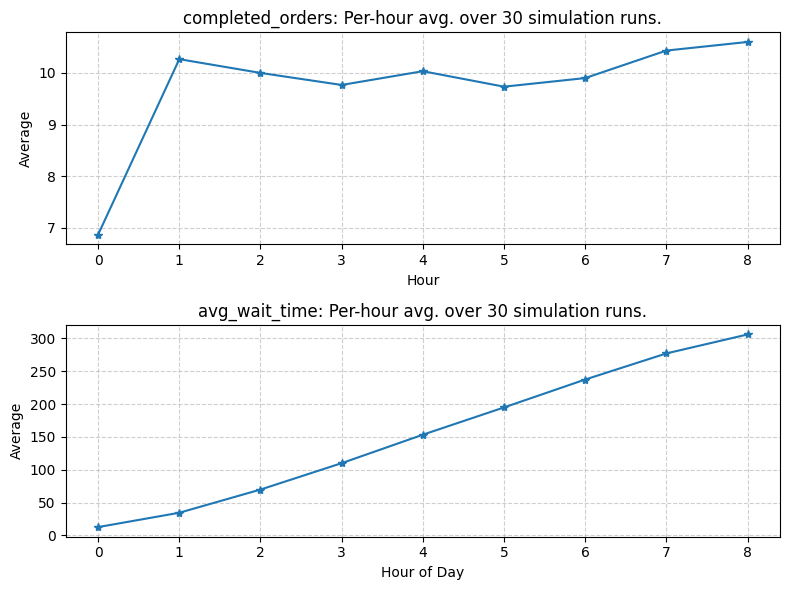

In [59]:
print_all_averages_per_hour(exp_0_res, 1)
# TODO: Need to average more things.
plot_all_averages_per_hour(exp_0_res)

In this "bare minimum" situation, we can see the average total wait time rises each hour. During the rush hour, which should hit its peak at the end of hour 2, many customers should be coming in and placing their order. As they cotinue to wait for ages and ages, the total wait time only keeps piling on.

*I should add some better graphs and stuff.

### Experiment 1: Average Staffing (The Original Setup)

The café currently has 1 register and 2 baristas working during all shifts, and has 1 coffee machine and 1 oven. We will run this to get a feel for how things usually are.

In [60]:
exp_nr      = 1
purpose     = AVERAGESTAFFED
exp_1_res   = run_experiment(exp_nr, purpose)

ValueError: not enough values to unpack (expected 10, got 5)

Let's take a look at the results of those runs.


Per hour averages across runs:

	arrivals:
	['13.7', '30.6', '32.0', '17.3', '8.4', '6.9', '6.3', '6.7', '3.9']

	completed_orders:
	['6.9', '10.3', '10.0', '9.8', '10.0', '9.7', '9.9', '10.4', '10.6']

	avg_wait_time:
	['12.7', '34.6', '69.8', '110.0', '153.3', '194.8', '237.3', '277.0', '305.9']



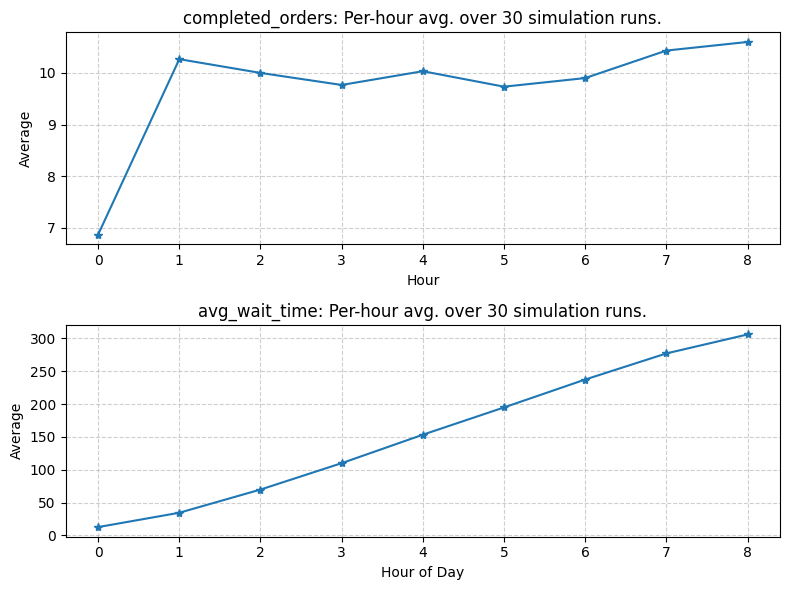

In [27]:
# # TODO: More will be added to this cell. 
# mean_per_hour = np.mean([stats.per_hour["completed_orders"] for stats in exp_res], axis=0)
# print(mean_per_hour)
# 
# print_all_averages_per_hour(exp_res, 1)
# 
# plot_all_multi(exp_res)

print_all_averages_per_hour(exp_0_res, 1)
# TODO: Need to average more things.
plot_all_averages_per_hour(exp_0_res)

[This is where we'd talk about the results, discuss what's on the graphs and such]. 

### Experiment 2: High Staffing

[Explain params of experiment, purpose of experiment,]

In [28]:
exp_nr      = 2
purpose     = HIGHSTAFFED
exp_2_res   = run_experiment(exp_nr, purpose)


| - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - |
| Number of coffee machines and ovens, ranked by optimality for staffing. |
| - - - - - - - - | - - - | - - - - - | - - - - - - - - - - - - | - - - - |
| coffee machines | ovens | mean wait | mean staff utilization  |  score  |
|               1 |     2 |    14.685 |                   0.431 |   0.643 |
|               2 |     2 |    15.976 |                   0.447 |   0.608 |
|               2 |     1 |    15.323 |                   0.439 |   0.604 |
|               1 |     1 |    15.201 |                   0.437 |   0.590 |
|               3 |     1 |    14.758 |                   0.433 |   0.579 |
| - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - |
| The optimal amount of machines for this staffing configuration is:      |
| - '1' coffee machines and '2' ovens.					  |
| - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - |


Let's take a look at the results of those runs.

In [29]:
# # TODO: More will be added to this cell. 
# mean_per_hour = np.mean([stats.per_hour["completed_orders"] for stats in exp_res], axis=0)
# print(mean_per_hour)
# 
# print_all_averages_per_hour(exp_res, 1)
# 
# plot_all_multi(exp_res)

[This is where we'd talk about the results, discuss what's on the graphs and such]. 

### Experiment 3: Full Staffing V1

[Explain params of experiment, purpose of experiment,]

In [30]:
exp_nr      = 3
purpose     = FULLSTAFFED_1
exp_3_res   = run_experiment(exp_nr, purpose)


| - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - |
| Number of coffee machines and ovens, ranked by optimality for staffing. |
| - - - - - - - - | - - - | - - - - - | - - - - - - - - - - - - | - - - - |
| coffee machines | ovens | mean wait | mean staff utilization  |  score  |
|               2 |     1 |    14.057 |                   0.407 |   0.657 |
|               3 |     1 |    13.726 |                   0.402 |   0.656 |
|               1 |     2 |    17.384 |                   0.417 |   0.653 |
|               1 |     1 |    18.235 |                   0.425 |   0.612 |
|               2 |     2 |    15.845 |                   0.416 |   0.585 |
| - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - |
| The optimal amount of machines for this staffing configuration is:      |
| - '2' coffee machines and '1' ovens.					  |
| - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - |


Let's take a look at the results of those runs.

In [31]:
print_all_averages_per_hour(exp_3_res, 1)


Per hour averages across runs:

	arrivals:
	['14.0', '29.7', '32.1', '17.0', '7.7', '6.3', '6.2', '6.8', '4.3']

	completed_orders:
	['9.9', '26.0', '29.1', '24.9', '9.6', '6.6', '6.1', '6.8', '5.0']

	avg_wait_time:
	['8.6', '11.6', '17.9', '20.0', '10.2', '7.6', '7.8', '7.2', '7.8']



In [32]:
# # TODO: More will be added to this cell. 
# mean_per_hour = np.mean([stats.per_hour["completed_orders"] for stats in exp_res], axis=0)
# print(mean_per_hour)
# 
# 
# 
# plot_all_multi(exp_res)

[This is where we'd talk about the results, discuss what's on the graphs and such]. 

### Experiment #4: Full Staffing V2

In this experiment, there will be full staffing during the rush hour period and a standard amount of staffing at other times. In particular, 1 register and 4 baristas will be present at rush hour in this experiment.

In [33]:
exp_nr      = 4
purpose     = FULLSTAFFED_2
exp_4_res   = run_experiment(exp_nr, purpose)


| - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - |
| Number of coffee machines and ovens, ranked by optimality for staffing. |
| - - - - - - - - | - - - | - - - - - | - - - - - - - - - - - - | - - - - |
| coffee machines | ovens | mean wait | mean staff utilization  |  score  |
|               2 |     1 |     9.229 |                   0.404 |   0.693 |
|               2 |     2 |     9.543 |                   0.405 |   0.672 |
|               1 |     2 |    10.424 |                   0.407 |   0.647 |
|               3 |     1 |     9.050 |                   0.387 |   0.633 |
|               1 |     1 |    10.810 |                   0.404 |   0.573 |
| - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - |
| The optimal amount of machines for this staffing configuration is:      |
| - '2' coffee machines and '1' ovens.					  |
| - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - |


### Comparing all experiments

Now that each experiment has been run, we will compare them all and put into a table.

In [34]:
compare(exp_1_results=exp_0_res, exp_2_results=exp_1_res, print_comparison=True)

--------------------------------------------------
Comparison of experiments:
--------------------------------------------------
Exp_1 mean wait:       161.296
Exp_1 mean utilization:0.609
Exp_1 composite score: 0.354
--------------------------------------------------
Exp_2 mean wait:       45.411
Exp_2 mean utilization:0.470
Exp_2 composite score: 0.704
--------------------------------------------------
Probability(exp_1 > exp_2) = 0.000
(Based on bootstrap of composite means)
--------------------------------------------------


{'exp_1': {'mean_wait': 161.2957503409024,
  'mean_utilization': 0.608979427053836,
  'composite_mean': 0.3535803405218678},
 'exp_2': {'mean_wait': 45.41094389909237,
  'mean_utilization': 0.4697029254782659,
  'composite_mean': 0.7037560014676598},
 'prob_exp_1_better': 0.0}

## Discussion of results

asdfghjklkjhgfdsdfghjkl

* I assume we'll add some ways to mathematically compare results, maybe make some nice graphs, talk about the differences.
* Explain where the bottleneck was, and how the best solution out of all of these fixes things.
* Et cetera.